--- 1. キャリア信号 (一定周期の矩形波) を生成中 ---
---    キャリア信号 生成完了 ---
--- 2. ベースバンド信号 (PN系列) を生成中 ---
---    ベースバンド信号 生成完了 ---
--- 3. 変調信号を生成中 ---
---    変調信号 生成完了 ---


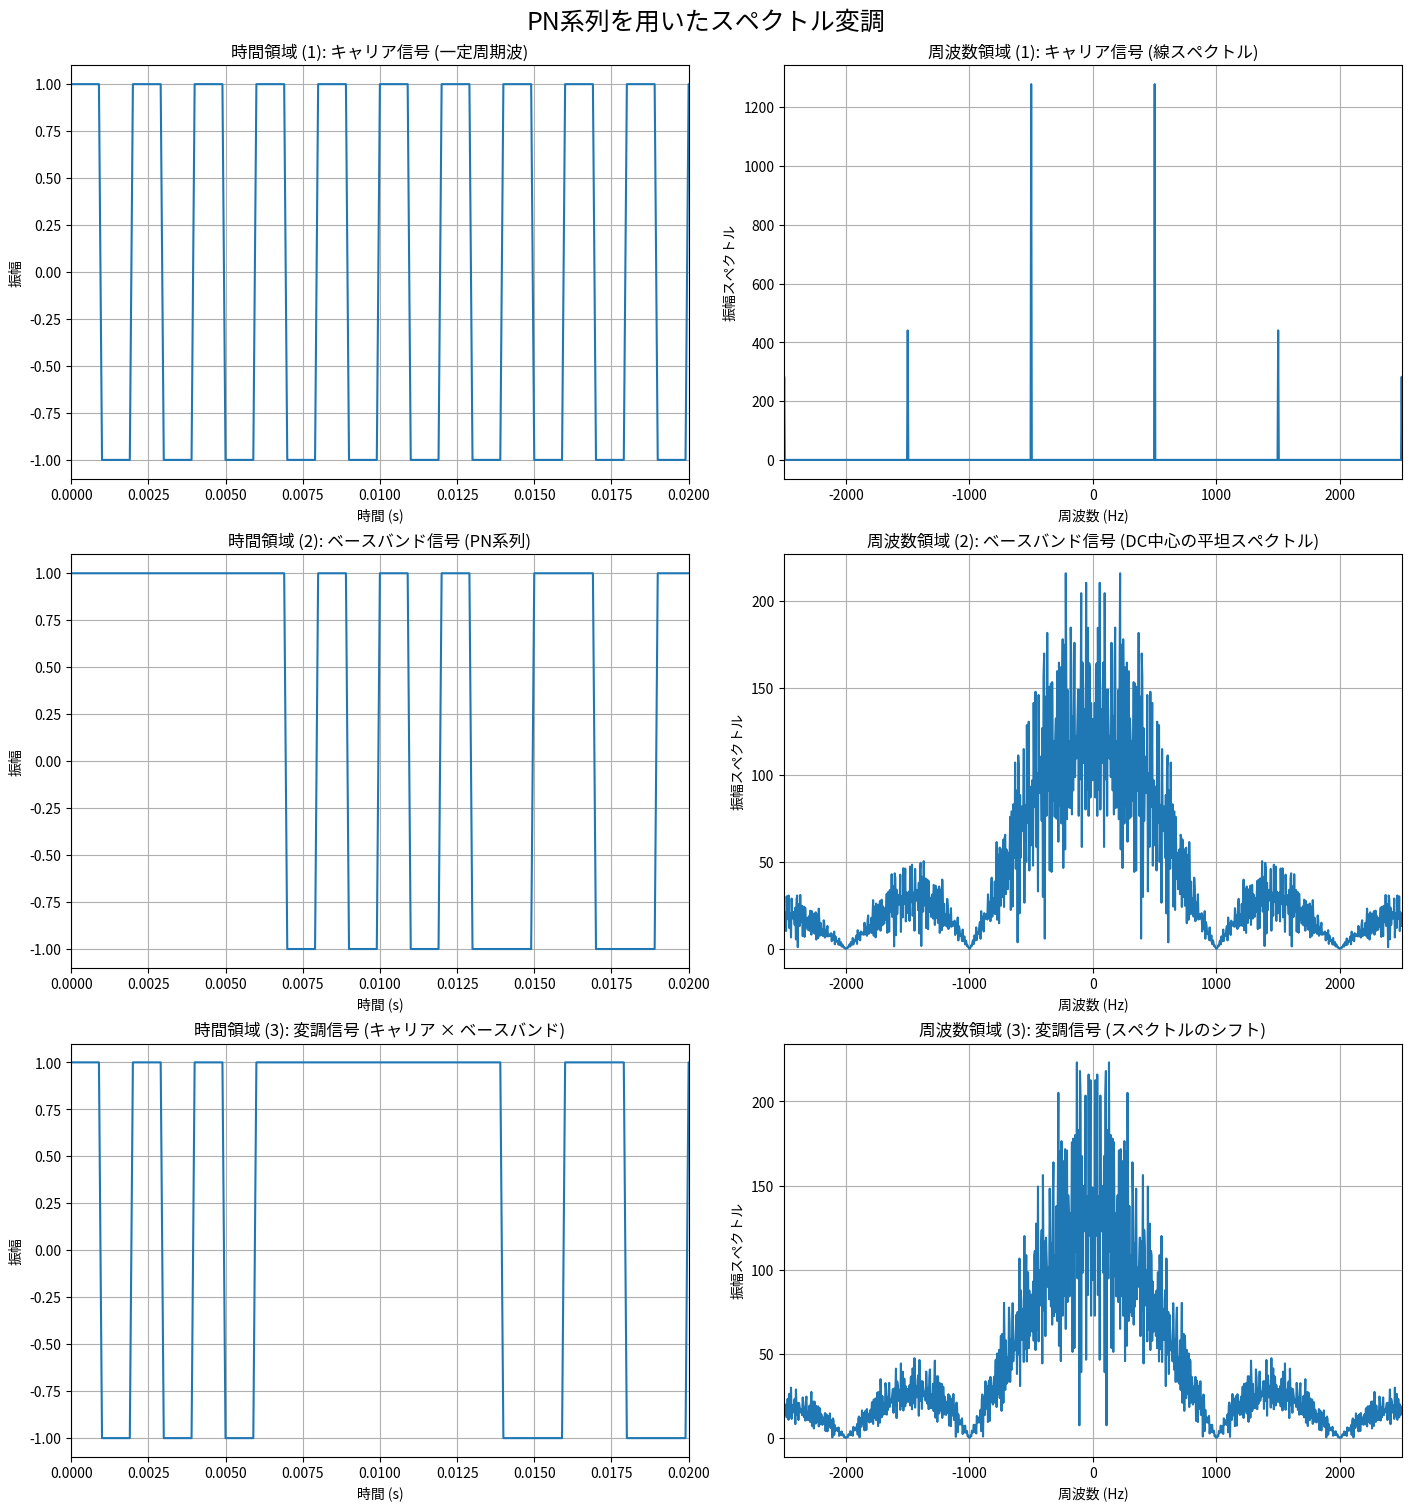

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import max_len_seq

# --- シミュレーションのパラメータ設定 ---
SAMPLING_RATE = 10000      # サンプリング周波数 (Hz)
DURATION = 0.2             # 信号の全長 (秒)
AMPLITUDE = 1.0            # 振幅
BASE_PULSE_WIDTH = 0.001   # 1ms (PN系列のチップ幅 & キャリアの半周期)

# --- 共通の変数を計算 ---
t = np.arange(0, DURATION, 1/SAMPLING_RATE)
n_samples = len(t)
samples_per_chip = int(BASE_PULSE_WIDTH * SAMPLING_RATE) # 1チップあたりのサンプル数

# --- 1. キャリア信号：一定周期の矩形波を生成 ---
print("--- 1. キャリア信号 (一定周期の矩形波) を生成中 ---")
# (+1)と(-1)が交互に切り替わる矩形波
# 周期は (2 * チップ幅), 周波数は 1 / (2 * BASE_PULSE_WIDTH) = 500 Hz
periodic_base_cycle = np.concatenate([
    np.full(samples_per_chip, AMPLITUDE),
    np.full(samples_per_chip, -AMPLITUDE)
])
n_repeats_periodic = int(np.ceil(n_samples / len(periodic_base_cycle)))
signal_carrier_long = np.tile(periodic_base_cycle, n_repeats_periodic)
signal_carrier = signal_carrier_long[:n_samples]
print("---    キャリア信号 生成完了 ---")

# --- 2. ベースバンド信号：PN系列(M系列)信号の生成 ---
print("--- 2. ベースバンド信号 (PN系列) を生成中 ---")
# M系列を生成 (7次の原始多項式 -> 2^7 - 1 = 127長の系列)
m_seq = max_len_seq(7)[0]
# 0/1 を -1/+1 に変換
pn_seq = (m_seq * 2 - 1).astype(float) * AMPLITUDE

# PN系列の各チップを、指定したサンプル数で時間信号に引き伸ばす
pn_signal_base = np.repeat(pn_seq, samples_per_chip)

# 信号の全長に合わせてPN系列波形を繰り返す
n_repeats_pn = int(np.ceil(n_samples / len(pn_signal_base)))
signal_baseband_long = np.tile(pn_signal_base, n_repeats_pn)
signal_baseband = signal_baseband_long[:n_samples]
print("---    ベースバンド信号 生成完了 ---")

# --- 3. 変調：キャリアとベースバンドを乗算 ---
print("--- 3. 変調信号を生成中 ---")
signal_modulated = signal_carrier * signal_baseband
print("---    変調信号 生成完了 ---")


# --- フーリエ変換の実行 ---
def compute_full_fft(signal, sampling_rate):
    """信号のFFTを計算し、プロット用にシフトした周波数軸と振幅スペクトルを返す"""
    n = len(signal)
    fft_result = np.fft.fft(signal)
    fft_amp = np.abs(fft_result)
    freq = np.fft.fftfreq(n, d=1/sampling_rate)
    return np.fft.fftshift(freq), np.fft.fftshift(fft_amp)

# 各信号のFFTを計算
freq_carrier, amp_carrier = compute_full_fft(signal_carrier, SAMPLING_RATE)
freq_baseband, amp_baseband = compute_full_fft(signal_baseband, SAMPLING_RATE)
freq_modulated, amp_modulated = compute_full_fft(signal_modulated, SAMPLING_RATE)

# --- 結果のプロット ---
# 3行2列のプロット領域を作成
fig, axes = plt.subplots(3, 2, figsize=(14, 15), constrained_layout=True)
fig.suptitle('PN系列を用いたスペクトル変調', fontsize=18)

# (1) 時間領域: キャリア信号 (一定周期波)
axes[0, 0].plot(t, signal_carrier)
axes[0, 0].set_title('時間領域 (1): キャリア信号 (一定周期波)')
axes[0, 0].set_xlabel('時間 (s)')
axes[0, 0].set_ylabel('振幅')
axes[0, 0].grid(True)
axes[0, 0].set_xlim(0, 0.02) # 見やすいように時間範囲を限定

# (2) 周波数領域: キャリア信号のスペクトル
axes[0, 1].plot(freq_carrier, amp_carrier)
axes[0, 1].set_title('周波数領域 (1): キャリア信号 (線スペクトル)')
axes[0, 1].set_xlabel('周波数 (Hz)')
axes[0, 1].set_ylabel('振幅スペクトル')
axes[0, 1].grid(True)
axes[0, 1].set_xlim(-SAMPLING_RATE / 4, SAMPLING_RATE / 4)

# (3) 時間領域: ベースバンド信号 (PN系列)
axes[1, 0].plot(t, signal_baseband)
axes[1, 0].set_title('時間領域 (2): ベースバンド信号 (PN系列)')
axes[1, 0].set_xlabel('時間 (s)')
axes[1, 0].set_ylabel('振幅')
axes[1, 0].grid(True)
axes[1, 0].set_xlim(0, 0.02) # 見やすいように時間範囲を限定

# (4) 周波数領域: ベースバンド信号のスペクトル
axes[1, 1].plot(freq_baseband, amp_baseband)
axes[1, 1].set_title('周波数領域 (2): ベースバンド信号 (DC中心の平坦スペクトル)')
axes[1, 1].set_xlabel('周波数 (Hz)')
axes[1, 1].set_ylabel('振幅スペクトル')
axes[1, 1].grid(True)
axes[1, 1].set_xlim(-SAMPLING_RATE / 4, SAMPLING_RATE / 4)

# (5) 時間領域: 変調信号 (キャリア × ベースバンド)
axes[2, 0].plot(t, signal_modulated)
axes[2, 0].set_title('時間領域 (3): 変調信号 (キャリア × ベースバンド)')
axes[2, 0].set_xlabel('時間 (s)')
axes[2, 0].set_ylabel('振幅')
axes[2, 0].grid(True)
axes[2, 0].set_xlim(0, 0.02) # 見やすいように時間範囲を限定

# (6) 周波数領域: 変調信号のスペクトル
axes[2, 1].plot(freq_modulated, amp_modulated)
axes[2, 1].set_title('周波数領域 (3): 変調信号 (スペクトルのシフト)')
axes[2, 1].set_xlabel('周波数 (Hz)')
axes[2, 1].set_ylabel('振幅スペクトル')
axes[2, 1].grid(True)
axes[2, 1].set_xlim(-SAMPLING_RATE / 4, SAMPLING_RATE / 4)

plt.show()
